# Introduction

In this notebook we explore the effectiveness of 3 models in predicting patient survival. Specifically we examine : 

1. Logistic Regression
2. Decision Tree
3. Random Forest

# Setup

## Data Ingestion

In [108]:
# Library Imports
import sqlite3 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score

import importlib
import helper as hp


In [2]:
# Load in data
conn = sqlite3.connect("../datasets/ICU_data.sqlite")
df = pd.read_sql_query(\
"""
SELECT 
    *
FROM ICU_data
"""
, con=conn)
conn.close()

In [3]:
df.head(2)

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,0,87,3,1,1,80,96,1
1,1,27,1,1,1,142,88,1


## Imbalanced Dataset

Note that the dataset is slightly imbalanced. The target class ratio is exactly <mark style='background-color: lightblue'> 4 : 1 </mark>, with the majority of patients surviving. 

In [25]:
(df.Survive.value_counts(normalize=True)*100).rename("Target Proportions")

1    80.0
0    20.0
Name: Target Proportions, dtype: float64

The <mark style='background-color: lightblue'>class imbalance is relatively slight at this ratio</mark>, so we may not necessarily need to account for this class imblance.

Depending on the model used we may also be able to handle this within the model itself. For exmaple with logistic regression we could assign a higher penalty to mistakes on the under-represented class. 

# Target recoding

This machine learning problem centers around predicting patient survival. In this case it is logical for us to focus __more__ on identifying patients that __do not survive__ so that more intervention could take place upon their arrival for better patient outcomes. 

With this in mind we can recode the target from `Survive` to `not_survive`, taking the reverse of the binary outcome for each recorded patient. This simplifies the performance assessment of each model later on as we pay special attention to predicting the class with target label == 1

In [80]:
# Target recording
df['not_survive'] = df['Survive'].apply(lambda x : 0 if x == 1 else 1)

## Non-Numeric Features

As mentioned previously, all non-numeric features (except for AgeGroup) are binary. This means we do not need to perform any encoding before using them as model inputs. 

## Train Test Split

Splitting the full dataset into the train and test set. 

__Note__ that we will not use `AgeGroup` as an input feature for the models, instead we will use `Age`

In [92]:
# Assign feature & target vectors
X, y = df[df.columns.difference(["Survive", 'not_survive', 'AgeGroup'])], df['not_survive']

In [93]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

Here we explore the effectiveness of a logistic regression applied to this machine learning problem. 

## Basic Logistic Regression

We begin with a basic linear regression model before exploring a hyper-parameter tuned version and compare the results. 

In [85]:
# Create basic logistic regression model, using out of the box parameters. 
logistic_clf = LogisticRegression(random_state=0, n_jobs=3)
# Fit onto training data
logistic_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=3, random_state=0)

In [96]:
# Predict on test data
prob_scores_test = logistic_clf.predict_proba(X_test)

### Performance Metrics

Here we discuss the performance metrics for this basic model 

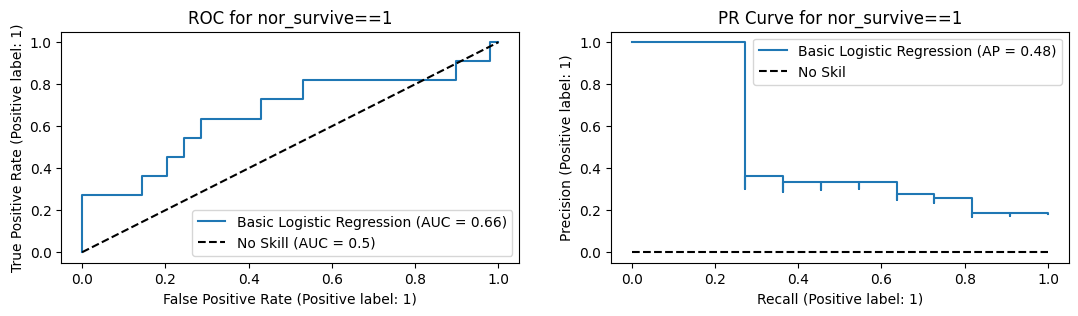

In [115]:
# plot ROC Curve. Class of interest is not_survive==1
class_id = np.flatnonzero(logistic_clf.classes_==1)[0]
# Plot the Metric curves
hp.plot_ROC_PR(y_test, prob_scores_test[:, class_id],\
     model_name= 'Basic Logistic Regression', label_to_plot="nor_survive==1")

From the ROC AUC we observe that the basic logistic regression performs better than random guessing. 

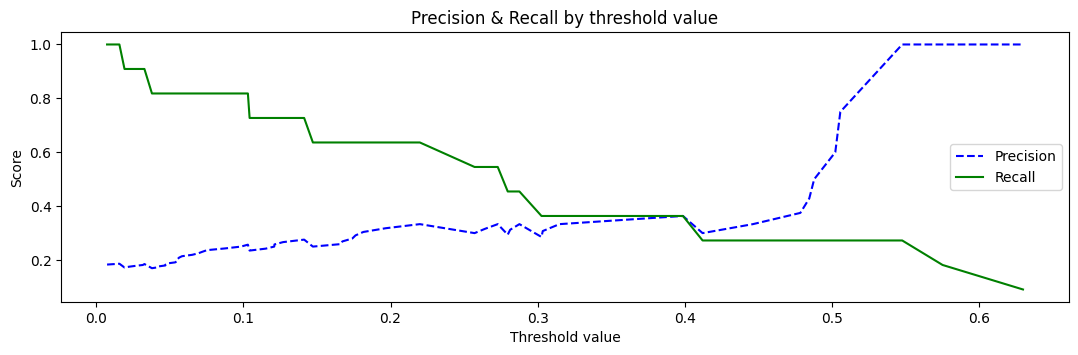

In [109]:
hp.plot_precision_recall_vs_threshold(y_test, prob_scores_test[:, class_id])

By default the logistic regression model assigns classes to the test datapoints using a threshold of 0.5. 

Given the [framework](#target-recoding) discussed earlier, this is likely ill-suited to our use case since 